In [1]:
import sys
import os
#import torch
import zarr
import fsspec
import lilio
import xarray as xr
import numpy as np
import pandas as pd
import pyarrow as pa
import matplotlib.pyplot as plt

#from torch import nn
from pathlib import Path

sys.path.append(os.path.expanduser('~/Documents/Medley'))
from scripts.prepare_monthly_ts_data import get_monthly_data

### Defining predictand

In [2]:
# blocks to include and exclude. Lonmin, latmin, lonmax, latmax
include = {'iberia':(-9.8,35.98,3.6,43.8),
          'france_italy':(4,43,13.4,45.63)}
exclude = {'islands':(0.79,35.2,4.6,40.4),
          'north_africa':(-1.450,34.457,11.217,36.972)}

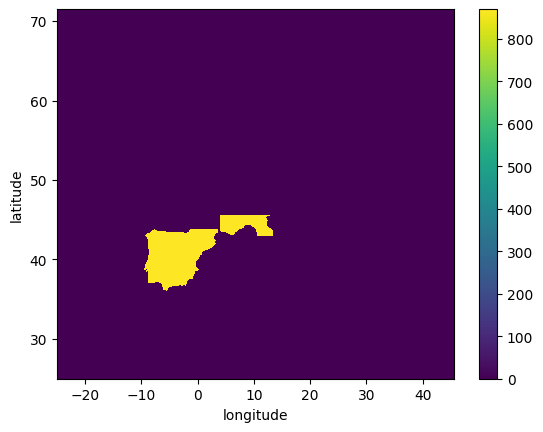

In [3]:
rrmon = xr.open_zarr('/scistor/ivm/jsn295/Medi/monthly/rr_mon_ens_mean_0.1deg_reg_v26.0e.zarr/')['rr']
example = rrmon.isel(time = 0, drop =True)
mask = xr.DataArray(np.full_like(example, 0), coords = example.coords)
def set_subset_to(lonmin, latmin, lonmax, latmax, array, value):
    lons = array.sel(longitude = slice(lonmin, lonmax)).longitude
    lats = array.sel(latitude = slice(latmin, latmax)).latitude
    array.loc[lats,lons] = value # cannot do .sel based assignment
for args in include.values():
    set_subset_to(*args, array = mask, value = 1)
for args in exclude.values():
    set_subset_to(*args, array = mask, value = 0)
count = xr.where(mask,rrmon,np.nan).count('time').compute()
count.plot()

In [4]:
target = xr.where(mask,rrmon,np.nan).mean(['longitude','latitude']).compute().to_pandas()

## relating to predictors

In [5]:
df = get_monthly_data().to_pandas()
df = df.loc[target.index,:]

In [6]:
cal = lilio.Calendar(anchor = '12-01')
cal.add_intervals("target", length="1M", gap = '0M')
cal.add_intervals("precursor", length="1M", n=1, gap = '-1M') # Fully co-occurring
cal.map_years(start=2021, end=2023)

Calendar(
    anchor='12-01',
    allow_overlap=False,
    mapping=('years', 2021, 2023),
    intervals=[
        Interval(role='target', length='1M', gap='0M'),
        Interval(role='precursor', length='1M', gap='-1M')
    ]
)

In [7]:
cal.show()

i_interval,-1,1
anchor_year,,
2023,"[2023-12-01, 2024-01-01)","[2023-12-01, 2024-01-01)"
2022,"[2022-12-01, 2023-01-01)","[2022-12-01, 2023-01-01)"
2021,"[2021-12-01, 2022-01-01)","[2021-12-01, 2022-01-01)"


In [8]:
lilio.resample(cal,target)

/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/utils.py:79: UserWarning: The input data could not fully cover the calendar's intervals. Intervals without available data will contain NaN values.
  warnings.warn(


,anchor_year,i_interval,interval,data,is_target
0,2021,-1,"[2021-12-01, 2022-01-01)",68.073807,False
1,2021,1,"[2021-12-01, 2022-01-01)",68.073807,True
2,2022,-1,"[2022-12-01, 2023-01-01)",NaN,False
3,2022,1,"[2022-12-01, 2023-01-01)",NaN,True
4,2023,-1,"[2023-12-01, 2024-01-01)",NaN,False
5,2023,1,"[2023-12-01, 2024-01-01)",NaN,True


In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

In [ ]:
model = NeuralNetwork().to('cuda')

In [ ]:
model(torch.randn((784,)).to('cuda'))